## <span style="color:#c70d39">**Proyecto Final**</span>
**Desarrollo de un Modelo de ML para Predecir la Severidad de los Accidentes en USA**</span>

### <span style="color:#ff5733">**Librerías a utilizar**</span>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import joblib
from skopt import BayesSearchCV
from skopt.callbacks import DeltaYStopper
from sklearn.preprocessing import label_binarize
from pickle import dump
from scipy.stats import uniform, randint



### <span style="color:#ff5733">**Cargando Data Preprocesada (Train y Test).**</span>

In [2]:
conn = sqlite3.connect('accidentes_usa.db')
cursor_obj = conn.cursor()

# Cargar los conjuntos de datos
X_train = pd.read_sql('SELECT * FROM X_train', conn)
X_test = pd.read_sql('SELECT * FROM X_test', conn)
y_train = pd.read_sql('SELECT * FROM y_train', conn)
y_test = pd.read_sql('SELECT * FROM y_test', conn)

# Cerrar la conexión
conn.close()

In [3]:
X_train.head()

,Start_Lat,Start_Lng,Traffic_Signal,Civil_Twilight,Temperature(F),Humidity(%)
0,0.582115,0.846743,0.0,1.0,0.515152,0.938776
1,0.717055,0.863890,0.0,1.0,0.323232,0.959184
2,0.488287,0.667733,0.0,1.0,0.212121,0.724490
3,0.543816,0.057136,0.0,1.0,0.555556,0.642857
4,0.664801,0.917162,0.0,1.0,0.363636,0.857143


In [4]:
# Convirtiendo la clase en series para correr en los modelos a evaluar
y_train=y_train['Severity']
y_test=y_test['Severity']

### <span style="color:#ff5733">**Funcion de Validación Cruzada.**</span>

In [5]:
# Realiza la validación cruzada con 5 folds
def val_cross(modelo):
    scores = cross_val_score(modelo, X_train, y_train, cv=10, scoring='accuracy')
    rounded_scores = np.round(scores, 4)
    print("Scores:", rounded_scores)
    print("Mean score:", round(scores.mean(),4))
    print("Standard deviation:", round(scores.std(),4))
    return

### <span style="color:#ff5733">**Modelo: Decision Tree.**</span>

In [18]:
model_dt = DecisionTreeClassifier(random_state = 42)
model_dt.fit(X_train, y_train)

y_pred_dt = model_dt.predict(X_test)
y_pred_dt

# Evaluar el modelo
print(classification_report(y_test, y_pred_dt))
accuracy = accuracy_score(y_test, y_pred_dt)


              precision    recall  f1-score   support

           1       0.70      0.71      0.70      4014
           2       0.58      0.54      0.56      4216
           3       0.56      0.56      0.56      4094
           4       0.55      0.58      0.56      3996

    accuracy                           0.60     16320
   macro avg       0.60      0.60      0.60     16320
weighted avg       0.60      0.60      0.60     16320



#### <span style="color:#FFC30F">**Optimizacion Modelo Decision Tree.**</span>

##### **RandomizedSearchCV.**

In [19]:
dt_space={'max_depth':[None, 50,100,500,1000], 
           'max_features':randint(1,6), 
           'criterion':['gini','entropy'], 
           'min_samples_leaf':randint(1,4), 
           'min_samples_split':np.arange(2, 10, step=2) 
          }

In [20]:
dt = DecisionTreeClassifier()
dt_random = RandomizedSearchCV(dt, dt_space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=5,verbose=2)
model_dt_rs = dt_random.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


In [21]:
print(f'Mejores Hiperparametros:: {model_dt_rs.best_params_}')
print(f'Mejor random search score es: {model_dt_rs.best_score_}')

Mejores Hiperparametros:: {'criterion': 'gini', 'max_depth': 50, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 8}
Mejor random search score es: 0.5928308823529411


In [24]:
model_dt_rs_f = DecisionTreeClassifier(criterion='gini', max_depth=50, max_features=5, min_samples_leaf=3, min_samples_split= 8, 
                                       random_state=42)
model_dt_rs_f.fit(X_train, y_train)



DecisionTreeClassifier(max_depth=50, max_features=5, min_samples_leaf=3,
                       min_samples_split=8, random_state=42)

In [25]:
y_pred_dt_rs = model_dt.predict(X_test)
y_pred_dt_rs

# Evaluar el modelo
print(classification_report(y_test, y_pred_dt_rs))
accuracy = accuracy_score(y_test, y_pred_dt_rs)


              precision    recall  f1-score   support

           1       0.70      0.71      0.70      4014
           2       0.58      0.54      0.56      4216
           3       0.56      0.56      0.56      4094
           4       0.55      0.58      0.56      3996

    accuracy                           0.60     16320
   macro avg       0.60      0.60      0.60     16320
weighted avg       0.60      0.60      0.60     16320



##### **GridSearchCV.**

In [26]:
grid_space={'max_depth':[5, 10, 20, 30, 50, 100, 200], 
           'max_features':[5,6], 
           'criterion':['entropy','gini'], 
           'min_samples_leaf':[2,3,4,5], 
           'min_samples_split':[2,3,4] 
          }

In [27]:
dt_gs = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt_gs, param_grid=grid_space, scoring='accuracy', cv=5, verbose=3)
model_grid_gs = dt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
[CV 1/5] END criterion=entropy, max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=2;, score=0.543 total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=2;, score=0.502 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=2;, score=0.543 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=2;, score=0.548 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=2;, score=0.528 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=3;, score=0.542 total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=3;, score=0.536 total time=   0.0

c:\Users\gfern\OneDrive\Escritorio\4GeeksAcademy\env_proyectofinal\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [28]:
print(f'Mejores Hiperparametros:: {model_grid_gs.best_params_}')
print(f'Mejor random search score es: {model_grid_gs.best_score_}')

Mejores Hiperparametros:: {'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 3}
Mejor random search score es: 0.6041666666666667


In [30]:
model_dt_gs_f = DecisionTreeClassifier(criterion='gini',max_depth=10, max_features=5, min_samples_leaf=3, min_samples_split=3,
           random_state=42)
           
model_dt_gs_f.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, max_features=5, min_samples_leaf=3,
                       min_samples_split=3, random_state=42)

In [31]:
y_pred_dt_gs = model_dt_gs_f.predict(X_test)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_dt_gs)}")
predicciones_exactas = accuracy_score(y_test, y_pred_dt_gs, normalize=False)
print("El número de predicciones exactas es: ", predicciones_exactas) 

Accuracy Score: 0.6021446078431373
El número de predicciones exactas es:  9827.0


In [32]:
from pickle import dump

dump(model_dt_gs_f, open("../models/model_decisiontree_42_con_scal.sav", "wb"))

### <span style="color:#ff5733">**Modelo: Regresión Logística.**</span>

In [6]:
# Crear el modelo
model_lr = LogisticRegression()


# Entrenar el modelo
model_lr.fit(X_train, y_train)

# Hacer predicciones
y_pred_lr = model_lr.predict(X_test)
y_pred_lr

# Evaluar el modelo
print(classification_report(y_test, y_pred_lr))
accuracy = accuracy_score(y_test, y_pred_lr)


              precision    recall  f1-score   support

           1       0.48      0.56      0.52      4014
           2       0.47      0.46      0.46      4216
           3       0.40      0.43      0.41      4094
           4       0.43      0.35      0.38      3996

    accuracy                           0.45     16320
   macro avg       0.45      0.45      0.44     16320
weighted avg       0.45      0.45      0.44     16320



#### <span style="color:#FFC30F">**Optimizacion Modelo Regresión Logística.**</span>

##### **RandomSearchCV.**

In [19]:
# Definición del modelo de regresión logística
model = LogisticRegression()

# Definición de los parámetros a optimizar
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000]
}

# Definición del RandomizedSearch
model_lr_rs = RandomizedSearchCV(model, param_grid, cv=5, n_iter=10, random_state=42, error_score='raise')

# Entrenamiento del modelo con RandomizedSearch
model_lr_rs.fit(X_train, y_train)

# Impresión de los resultados
print("Mejores parámetros:", model_lr_rs.best_params_)
print("Mejor puntuación:", model_lr_rs.best_score_)

Mejores parámetros: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 100, 'C': 1}
Mejor puntuación: 0.44909620098039216


##### **GridSearchCV.**

In [29]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin


# Definición del modelo de regresión logística
model = LogisticRegression()

# Definición de los parámetros a optimizar con GridSearchCV
param_grid = [
    {'solver': ['liblinear', 'saga'], 'penalty': ['l1'], 'C': [0.1, 1.5, 2], 'max_iter': [100,500], 'tol': [1e-4, 1e-5]},
    {'solver': ['lbfgs', 'saga'], 'penalty': ['l2'], 'C': [0.1, 1.5, 2], 'max_iter': [100,500], 'tol': [1e-4, 1e-5]},
    {'solver': ['saga'], 'penalty': ['elasticnet'], 'C': [0.1, 1.5, 2], 'max_iter': [100,500], 'tol': [1e-4, 1e-5], 'l1_ratio': [0.1, 0.5, 0.7]}
]

model_lr_gs = GridSearchCV(model, param_grid, cv=5, verbose=2, n_jobs=-1)

model_lr_gs.fit(X_train, y_train)

# Impresión de los resultados
print("Mejores parámetros:", model_lr_gs.best_params_)
print("Mejor puntuación:", model_lr_gs.best_score_)


Fitting 5 folds for each of 84 candidates, totalling 420 fits
Mejores parámetros: {'C': 2, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 1e-05}
Mejor puntuación: 0.44914215686274506


In [30]:
from pickle import dump

dump(model_lr_rs, open("../models/model_regresionlogistic_42_con_scal.sav", "wb"))

### <span style="color:#ff5733">**Modelo: SVC.**</span>

In [45]:
# Crear el modelo
model_svc_def = SVC(kernel = "linear", random_state = 42)

# Entrenar el modelo
model_svc_def.fit(X_train, y_train)

# Hacer predicciones
y_pred_svc_def= model_svc_def.predict(X_test)
y_pred_svc_def

# Evaluar el modelo
accuracy_score(y_test, y_pred_svc_def)

0.44362745098039214

#### <span style="color:#FFC30F">**Optimizacion Modelo SVC.**</span>

##### **GridSearchCV.**

In [7]:

# Define the parameter grid
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

# Create the model
model_svc = SVC(random_state=42, cache_size=500)

# Perform grid search
model_svc_gs = GridSearchCV(model_svc, param_grid, cv=5, scoring='accuracy',verbose=2,n_jobs=-1)
model_svc_gs.fit(X_train, y_train)

# Get the best parameters and the corresponding score
best_params = model_svc_gs.best_params_
best_score = model_svc_gs.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)

# Train the model with the best parameters
model_svc_best = SVC(**best_params, random_state=42)
model_svc_best.fit(X_train, y_train)

# Make predictions
y_pred_svc_best = model_svc_best.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_svc_best)
print("Accuracy:", accuracy)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.5446231617647058
Accuracy: 0.5447303921568627


In [12]:
# Crear el modelo
model_svc_gs = SVC(C= 10, gamma= 'scale',kernel= 'rbf', random_state = 42)

# Entrenar el modelo
model_svc_gs.fit(X_train, y_train)

# Hacer predicciones
y_pred_svc_gs= model_svc_gs.predict(X_test)

# Evaluar el modelo
accuracy_score(y_test, y_pred_svc_gs)

0.5447303921568627

In [13]:
from pickle import dump

dump(model_svc_gs, open("../models/model_SVCclasiffier_42_con_scal.sav", "wb"))

### <span style="color:#ff5733">**Modelo: Random Forest.**</span>

#### <span style="color:#FFC30F">**Inicialización y entrenamiento del modelo.**</span>

In [6]:
# Crear el modelo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### <span style="color:#FFC30F">**Predicción del Modelo.**</span>

In [7]:
# Hacer predicciones
y_pred = rf_model.predict(X_test)

In [8]:
print(f"Accuracy Score: {np.round(accuracy_score(y_test, y_pred),3)}")
predicciones_exactas = accuracy_score(y_test, y_pred, normalize=False)
print("El número de predicciones exactas es: ", predicciones_exactas) 

Accuracy Score: 0.663
El número de predicciones exactas es:  10814.0


funcion de Validacion Cruzada para probar la consistencia de los modelos a desarrollar

In [20]:
val_cross(rf_model)

Scores: [0.6627 0.6615 0.6616 0.6636 0.6648 0.6619 0.6684 0.659  0.6566 0.6595]
Mean score: 0.6619
Standard deviation: 0.0031


#### <span style="color:#FFC30F">**Optimizacion Modelo RandomForest.**</span>

##### **BayesSearchCV.**

In [42]:
from skopt.callbacks import DeltaYStopper

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [300, 400, 500],
    'criterion': ['entropy'],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [5, 10,15],
    'min_samples_leaf': [1, 5,7,9],
    'max_features': ['sqrt', 'log2', None]
}

# Creación del objeto BayesSearchCV
model_rs = BayesSearchCV(estimator=RandomForestClassifier(), search_spaces=param_grid, n_iter=200, cv=10, scoring='accuracy', n_jobs=-1, 
                         verbose=3)

# Definir el early stopper
early_stopper = DeltaYStopper(delta=0.01, n_best=5)

# Definir una función de callback para imprimir el número de iteración y el accuracy
def on_iter(optim_result):
    iteration = len(optim_result.x_iters)
    current_score = optim_result.func_vals[-1]
    best_score = max(optim_result.func_vals)
    print(f"Iteración {iteration}/{model_rs.total_iterations}: Accuracy en la iteración actual: {current_score:.4f}")
    print(f"Mejor accuracy hasta ahora: {best_score:.4f}")
        
# Entrenar el modelo con early stopping y callback
model_rs.fit(X_train, y_train, callback=[early_stopper, on_iter])

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

BayesSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=200, n_jobs=-1,
              scoring='accuracy',
              search_spaces={'criterion': ['entropy'],
                             'max_depth': [None, 10, 15, 20],
                             'max_features': ['sqrt', 'log2', None],
                             'min_samples_leaf': [1, 5, 7, 9],
                             'min_samples_split': [2, 5, 10, 15],
                             'n_estimators': [300, 400, 500]},
              verbose=3)

In [43]:
print("Mejor puntuación:", np.round(model_rs.best_score_,3))
print("Mejores hiperparámetros:", model_rs.best_params_)

Mejor puntuación: 0.672
Mejores hiperparámetros: OrderedDict({'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500})


##### **Mejor Modelo BayesSearchCV.**

In [39]:
# Entrenar un nuevo modelo con los mejores hiperparámetros
model_rs_final = RandomForestClassifier(criterion='entropy', max_depth= None, max_features= None, min_samples_leaf=2,
                                        min_samples_split=5, n_estimators= 300, random_state=42)
model_rs_final.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=None,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300, random_state=42)

In [41]:
# Hacer predicciones
y_pred_rs = model_rs_final.predict(X_test)

In [42]:
print(f"Accuracy Score: {np.round(accuracy_score(y_test, y_pred_rs),3)}")
predicciones_exactas = accuracy_score(y_test, y_pred_rs, normalize=False)
print("El número de predicciones exactas es: ", predicciones_exactas) 

Accuracy Score: 0.674
El número de predicciones exactas es:  10992.0


##### **Validacion Cruzada Modelo Seleccionado.**

In [47]:
val_cross(model_rs_final)

Scores: [0.6737 0.6665 0.668  0.6722 0.6687 0.668  0.6772 0.6734 0.6676 0.672 ]
Mean score: 0.6707
Standard deviation: 0.0033


##### **GridSearchCV combinado con el BayesSearchCV.**

In [48]:
# Definir el espacio de búsqueda de hiperparámetros ajustado
param_grid_gs = {
    'n_estimators': [300, 400,500],  # Ajustado alrededor del mejor valor encontrado
    'criterion': ['entropy'],
    'max_depth': [None, 15],  # Ajustado alrededor del mejor valor encontrado
    'min_samples_split': [2, 5, 10],  # Ajustado alrededor del mejor valor encontrado
    'min_samples_leaf': [1, 2,3],  # Ajustado alrededor del mejor valor encontrado
    'max_features': [None],  # Ajustado para incluir opciones válidas
    'random_state': [42]
}

# Crear un objeto GridSearchCV
model_gs = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid_gs,
    cv=5,
    scoring='accuracy',
    verbose=3,
    n_jobs=-1
)

# Definir una función de early stopping manual
def early_stopping_search(cv_results, delta=0.01, iter_comp=5):
    best_scores = cv_results['mean_test_score']
    
    for i in range(len(best_scores) - iter_comp):
        print(f'{i} de 162')
        if np.all(np.abs(np.diff(best_scores[i:i+iter_comp])) < delta):
            print(f"Early stopping at iteration {i + iter_comp}")
            return True
    return False

# Entrenar el modelo con los datos de entrenamiento
model_gs.fit(X_train, y_train)

# Verificar si se debe detener la búsqueda
if early_stopping_search(model_gs.cv_results_):
    print("Early stopping triggered")


Fitting 5 folds for each of 54 candidates, totalling 270 fits
0 de 162
Early stopping at iteration 5
Early stopping triggered


In [53]:
print("Mejor puntuación:", np.round(model_gs.best_score_,3))
print("Mejores hiperparámetros:", model_gs.best_params_)

Mejor puntuación: 0.666
Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400, 'random_state': 42}


In [5]:
# Entrenar un nuevo modelo con los mejores hiperparámetros
model_gs_final = RandomForestClassifier(criterion='entropy', max_depth= None, max_features= None, min_samples_leaf=1,
                                        min_samples_split= 5, n_estimators= 400, random_state=42)
model_gs_final.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=None,
                       min_samples_split=5, n_estimators=400, random_state=42)

In [6]:
# Hacer predicciones
y_pred_gs = model_gs_final.predict(X_test)

In [7]:
print(f"Accuracy Score: {np.round(accuracy_score(y_test, y_pred_gs),3)}")
predicciones_exactas = accuracy_score(y_test, y_pred_gs, normalize=False)
print("El número de predicciones exactas es: ", predicciones_exactas) 

Accuracy Score: 0.674
El número de predicciones exactas es:  10994.0


##### **Guardando Modelo RandomForest Optimizado Escalado.**

In [43]:
from pickle import dump

dump(model_rs_final, open("../models/model_randomforestclasiffier_42_con_scal.sav", "wb"))

##### **Modelo sin escalamiento**

In [16]:
conn = sqlite3.connect('accidentes_usa.db')
cursor_obj = conn.cursor()

# Cargar los conjuntos de datos
X_train_r_sin_scal = pd.read_sql('SELECT * FROM X_train_r_sin_scal', conn)
X_test_r_sin_scal = pd.read_sql('SELECT * FROM X_test_r_sin_scal', conn)
y_train_r_sin_scal = pd.read_sql('SELECT * FROM y_train_r_sin_scal', conn)
y_test_r_sin_scal = pd.read_sql('SELECT * FROM y_test_r_sin_scal', conn)

# Cerrar la conexión
conn.close()

In [23]:
y_train_r_sin_scal=y_train_r_sin_scal['Severity']
y_test_r_sin_scal=y_test_r_sin_scal['Severity']

In [30]:
y_test_r_sin_scal.isnull().sum()

0

In [24]:
modelo_rf_sin_scal= RandomForestClassifier(criterion='entropy', max_depth= None, max_features= None, min_samples_leaf=2,
                                        min_samples_split=5, n_estimators= 300, random_state=42)
modelo_rf_sin_scal.fit(X_train_r_sin_scal, y_train_r_sin_scal)

RandomForestClassifier(criterion='entropy', max_features=None,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300, random_state=42)

In [25]:
# Hacer predicciones
y_pred_rf_sin_scal = modelo_rf_sin_scal.predict(X_test_r_sin_scal)
print(f"Accuracy Score: {np.round(accuracy_score(y_test_r_sin_scal, y_pred_rf_sin_scal),3)}")
predicciones_exactas = accuracy_score(y_test_r_sin_scal, y_pred_rf_sin_scal, normalize=False)
print("El número de predicciones exactas es: ", predicciones_exactas) 

Accuracy Score: 0.654
El número de predicciones exactas es:  6536.0


In [26]:
from pickle import dump

dump(modelo_rf_sin_scal, open("../models/model_randomforestclasiffier_42_sin_scal.sav", "wb"))

#### <span style="color:#ff5733">**Revisión de Métricas Rendimiento Modelo Seleccionado y Optimizado: Random Forest.**</span> 

##### **Curva ROC Clase Severity**

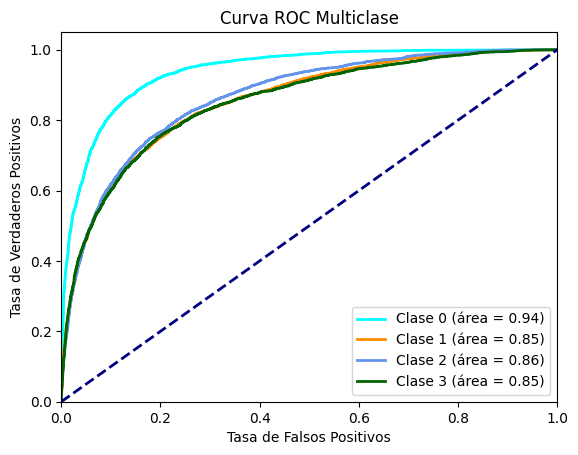

In [18]:
# Binarizar las etiquetas para la clasificación multiclase
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]


# Predecir las probabilidades en el conjunto de prueba
y_pred_proba = model_rs_final.predict_proba(X_test)

# Calcular la curva ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar la curva ROC para cada clase
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen']  # Añadir más colores si es necesario
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Clase {i} (área = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Multiclase')
plt.legend(loc="lower right")
plt.show()






##### **Matriz Confusión Clase Severity**

In [33]:
unique1, counts1 = np.unique(y_train, return_counts=True)

print(dict(zip(unique1, counts1)))


{1: 16386, 2: 16184, 3: 16306, 4: 16404}


In [31]:
y_test.value_counts()

Severity
2    4216
3    4094
1    4014
4    3996
Name: count, dtype: int64

In [28]:
unique, counts = np.unique(y_pred, return_counts=True)

print(dict(zip(unique, counts)))


{1: 4386, 2: 3863, 3: 4082, 4: 3989}


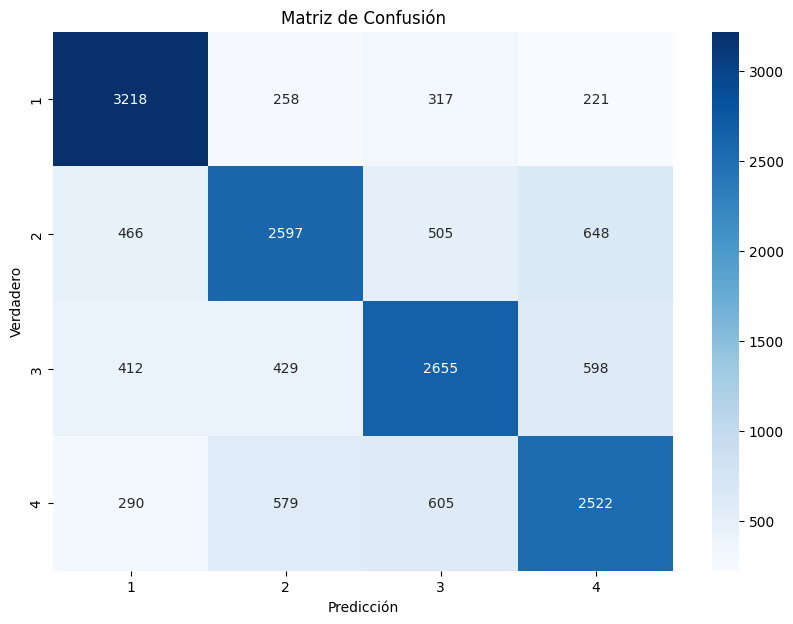

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener las predicciones del modelo
y_pred = model_rs_final.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear una visualización de la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

In [20]:
# Generar el reporte de clasificación
report = classification_report(y_test, y_pred, target_names=[f'Clase {i}' for i in np.unique(y_test)])
print(report)

              precision    recall  f1-score   support

     Clase 1       0.73      0.80      0.77      4014
     Clase 2       0.67      0.62      0.64      4216
     Clase 3       0.65      0.65      0.65      4094
     Clase 4       0.63      0.63      0.63      3996

    accuracy                           0.67     16320
   macro avg       0.67      0.67      0.67     16320
weighted avg       0.67      0.67      0.67     16320



##### **Observaciones finales sobre el modelo seleccionado**

Precisión:

  - La precisión mide la proporción de verdaderos positivos (Tp) sobre el total de predicciones (Tp + Fp).
    - Clase 1: Tiene la mayor precisión con 0.73, lo que indica que el modelo es bastante bueno para identificar correctamente los ejemplos de esta clase.
    - Clase 4: Tiene la menor precisión con 0.63, lo que sugiere que hay más falsos positivos en esta clase.

Recall (Sensibilidad):

  - El recall mide la proporción de verdaderos positivos (Tp) sobre el total de ejemplos reales de la clase (Tp+Fn).
    - Clase 1: También tiene el mayor recall con 0.80, indicando que el modelo es efectivo para capturar la mayoría de los ejemplos de esta clase.
    - Clase 2: Tiene el menor recall con 0.62, lo que significa que el modelo está perdiendo más ejemplos de esta clase.

F1-Score:
  - El F1-score es la media armónica de la precisión y el recall, proporcionando un balance entre ambos.
    - Clase 1: tiene el mayor F1-score con 0.77, lo que confirma que el modelo tiene un buen rendimiento en esta clase.
    - Clase 4: tiene el menor F1-score con 0.63, indicando que el rendimiento del modelo es más bajo para esta clase.

Finalmente, podemos agregar que la exactitud global del modelo de 0.67 es moderada. Se exploraron técnicas adicionales de mejora como:
  - Ajuste de Hiperparámetros: Técnicas como BayesSearch y GridSearch para encontrar los mejores parámetros.
  - Selección de características: Técnicas como SelectKbest de la librería de sklearn.
  - Feature Engineering: Se creo una variable llamada duración basada en la fecha de inicio y final del accidente.
  - Se usaron varios tipos de modelos, entre ellos, varias combinaciones de aprendizaje profundo (redes neuronales multicapa)

Este modelo tiene consistencia, observada en los resultados de la curva ROC y la validación cruzada, los cuales son cónsonos con el reporte de clasificación, sugiriendo un rendimiento estable y predecible.

Pensamos que deben medirse otras características adicionales para mejorar el accuracy de cualquier modelo a utilizar en un futuro cercano.